In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import cbsyst as cb

In [19]:
Ks = cb.calc_Ks()
KspA = Ks['KspA']

In [ ]:
def calc_D_TE(R):
    return 1e-3 - 10 * R

def biomin_box(t, state, z, rho, K, F_H, F_Ca, F_HCO3, D_CO2, x_CO2, p_H_Ca, k_rate, n_rate, Ca_sw, DIC_sw, TA_sw, TE_sw, CO2_sw): 
    Ca, DIC, TA, TE = state

    cs = cb.Csys(TA=TA*1e6, DIC=DIC*1e6)  # could swap this out for a more efficient version
    CO3 = cs.CO3[0] * 1e-6
    CO2 = cs.CO2[0] * 1e-6
        
    Omega = CO3 * Ca / KspA
    
    R = max(0, k_rate * (Omega - 1)**n_rate)
    
    dCa = K * (Ca_sw - Ca) + (F_Ca + p_H_Ca * F_H - R) / z / rho # - pinocytosis?
    dDIC = K * (DIC_sw - DIC) + (F_HCO3 - R) / z / rho + D_CO2 * (CO2_sw - CO2) / 100e-6 / z # - pinocytosis?
    dTA = K * (TA_sw - TA) + (F_H + F_HCO3 - 2 * R) / z / rho # - pinocytosis?
    
    # for each trace element...
    D_TE = calc_D_TE(R)
    dTE = K * (TE_sw - TE) - R * D_TE * (TE / Ca) / z / rho   # - pinocytosis?
    # + other processes for TE?
    
    return [dCa, dDIC, dTA, dTE]

In [353]:
z = 10e-6
rho = 1025
K = 0.2
F_H = 1e-4
F_Ca = 0
F_HCO3 = 0
D_CO2 = 1e-6
x_CO2 = 100e-6
p_H_Ca = 0.5
k_rate = 1e-6
n_rate = 1.8
Ca_sw = 10.2e-3
DIC_sw = 3200e-6
TA_sw = 3200e-6

TE_sw = 50e-3

sw = cb.Csys(TA=TA_sw*1e6, DIC=DIC_sw*1e6)

args = (z, rho, K, F_H, F_Ca, F_HCO3, D_CO2, x_CO2, p_H_Ca, k_rate, n_rate, Ca_sw, DIC_sw, TA_sw, TE_sw, sw.CO2[0] * 1e-6)

sol = solve_ivp(biomin_box, [0, 40], [Ca_sw, DIC_sw, TA_sw, TE_sw], args=args, rtol=1e-7, atol=1e-9)

In [354]:
Ca, DIC, TA, TE = sol.y

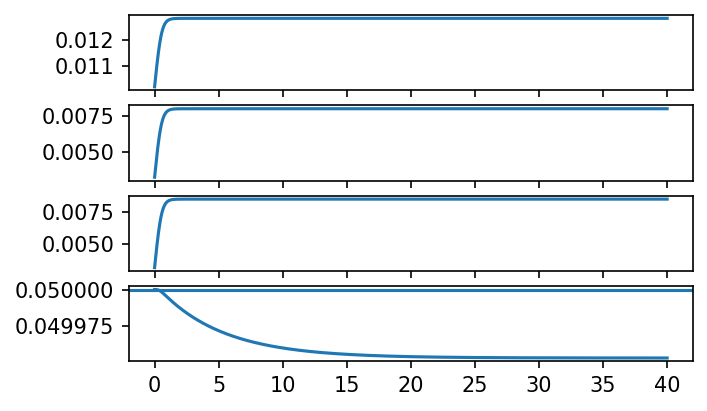

In [355]:
fig, axs = plt.subplots(4, 1, sharex=True)

axs[0].plot(sol.t, Ca, label='Ca')
axs[1].plot(sol.t, DIC, label='DIC')
axs[2].plot(sol.t, TA, label='TA')

axs[3].plot(sol.t, TE, label='TE')
axs[3].axhline(TE_sw)


In [356]:
cf = cb.Csys(TA=TA*1e6, DIC=DIC*1e6)
Omega = cf.CO3 * 1e-6 * Ca / KspA

R = k_rate * (Omega - 1)**n_rate

f_Rayleigh = Ca / Ca_sw

TE_Ca = calc_D_TE(R) * (TE / Ca)


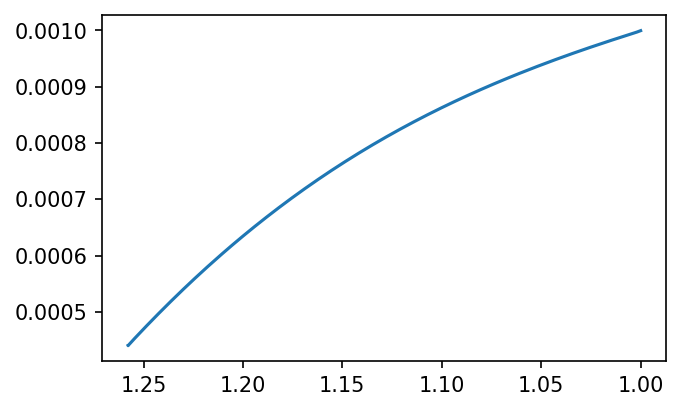

In [357]:
plt.plot(f_Rayleigh, TE_Ca / (TE_sw / Ca_sw))
plt.gca().invert_xaxis()

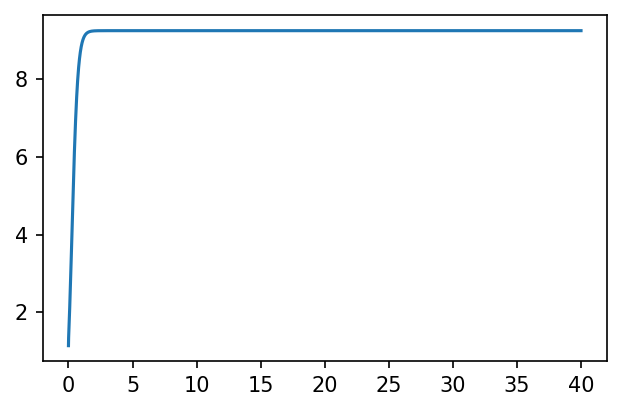

In [358]:
plt.plot(sol.t, Omega, label='Omega')

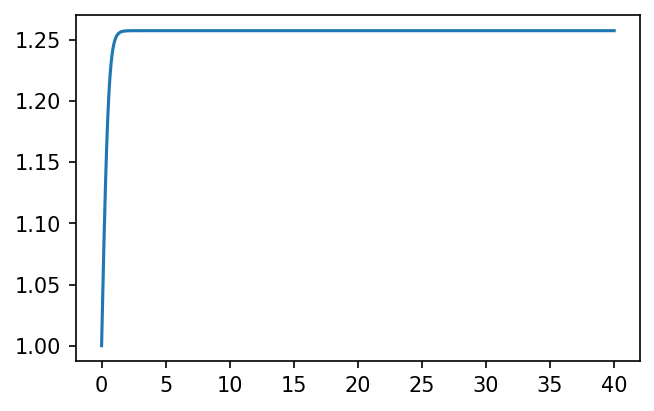

In [359]:
plt.plot(sol.t, f_Rayleigh, label='R')

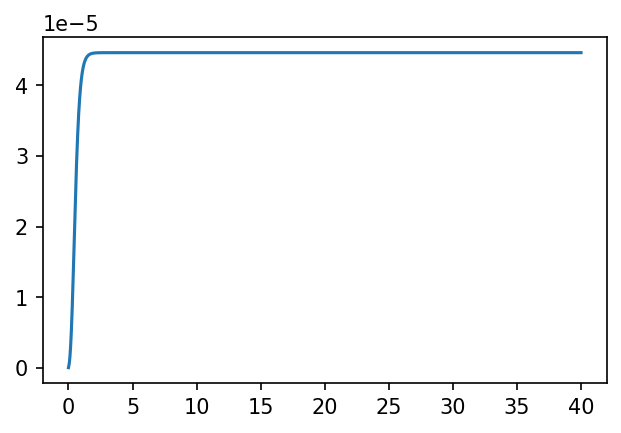

In [360]:
plt.plot(sol.t, R, label='R')

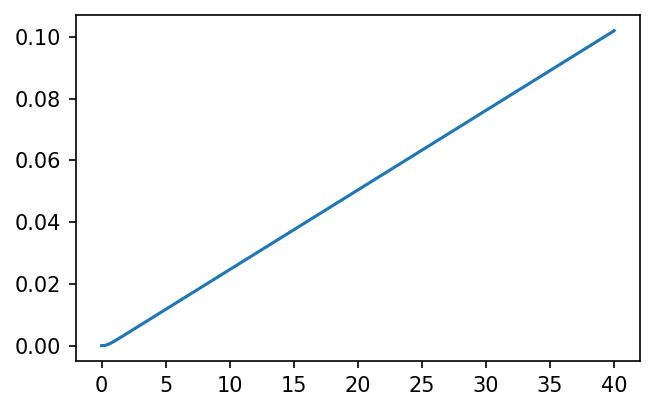

In [361]:
plt.plot(sol.t, np.cumsum(R), label='R')

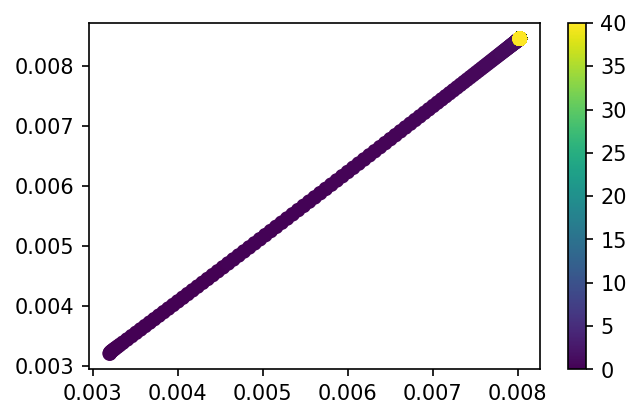

In [362]:
plt.scatter(DIC, TA, c=sol.t)
plt.colorbar()